# Hullception: Image Decomposition with Many Convex Hulls

In [1]:
# import deps
import PIL.Image
import scipy.cluster
import scipy.spatial
import numpy as np

In [2]:
# open image and save into `points`
with PIL.Image.open("turquoise.png") as image:
    points = np.array(image)/255  # [0, 255] -> [0, 1]
    w, h = points.shape[:2]
    points = points.reshape((w*h, 3)) # [x][y][rgb] -> [i][rgb]
    # remove colors made identical with above dimension drop
    points = np.unique(points, axis=0)

# So What is an Outlier?

> [Wikipedia] In statistics, an outlier is a data point that differs significantly from other observations.

When looking at the above definition in the context of image decomposition, it doesn't really make sense.  An image could have a small splotch of yellow/orange while the rest of the image is blue (the splotch is sometimes the Sun), and by the above definition, this splotch would be considered an outlier.  The outliers we are interested in aren't outliers in a statistical sense; rather, they are defined in terms of their effects on the image and the perceived color palette of that image.

**Definition 1.** *An outlier is a point of a group of points whose existance significantly affects the shape of the convex hull containing all of the groups of points and whose removal has an insignificant effect on the image.*

## "whose existance significantly affects the shape of the convex hull containing all of the groups of points..."

- First, divide the points into groups such that every point is in exactly *one* group.  This can be done with clustering algorithms such as [k-means](https://en.wikipedia.org/wiki/K-means_clustering) or tessellation methods such as [Delaunay tessellations](https://en.wikipedia.org/wiki/Delaunay_triangulation) (though the two are actually related).  
- Then, calculate the convex hull of each of the points, the convex hull of the union of all of the groups, and the volumes of each of these hulls.  From now on, the convex hull of the union of all of the groups is called the "large hull" and the convex hull of an individual group is called a "small hull".
- For each of the small hulls that lie on the border of the large hull, find the small hull that decreases the volume of a large hull the most when the large hull is recalculated to exclude the small hull (<span style="color: #D19A66">NOTE we might also want to try just keeping track of the small hull with the largest volume.  These two are not guaranteed to be the same, and in fact are likely not</span>). 
- If the removal of the small hull found above would reduce the volume of the larger convex hull past a threshold, then it's existance significantly affects the shape of the convex hull containing all of the groups of points.

## "...whose removal has an insignificant effect on the image"

[<span style="color: red">TODO</span>]

# Introduction of k-means

K-means is a clustering algorithm that assembles $k$ groups of points based on how close they are to each other.  Working with groups of points is a lot more efficient than working with points individually, and also has the added benefit that removing *only one* group will remove  *more than one* point.  In this context, a point is a color and a group is all of the points that share a similar color (where the color shows up in the image is ignored for now).  K-means can be used to create groups in order to identify groups whose existance significantly affects the shape of the convex hull containing all of the groups of points.  The following algorithm finds one such group:

*Given a set of $N$ points $p_i$ and an outlier percentage $\lambda$, run k-means with $k = \frac N {100 - \lambda}$, and then compute the convex hull $k$ times, leaving out one cluster each time. Return the smallest convex hull.*

In [3]:
λ = 5
N = points.shape[0] # not w*h since duplicates were removed
K = int(N / (100 - λ))
K=50
print(f"K = {K}")

K = 50


In [4]:
from IPython.display import clear_output
# create clusters using k-means
clusters = scipy.cluster.vq.kmeans2(points, K)
centroids, labels = clusters
# hide warning if a cluster was empty
clear_output(wait=True)
print(f"centroids: {centroids.shape}")
print(f"labels: {labels.shape}")

centroids: (50, 3)
labels: (61931,)


In [5]:
# create every hull that excludes exactly one cluster
hulls = list()
for label in range(K):
    # exclude the current label (a cluster)
    mask = np.where(labels != label)
    included = points[mask]
    # create convex hull
    hull = scipy.spatial.ConvexHull(included)
    hulls.append((hull, label))

In [6]:
# find the hull that has the smallest volume
smallest_hull, label = min(hulls, key=lambda hull: hull[0].volume)
starting_hull = scipy.spatial.ConvexHull(points)
print(f"volume reduced by {(starting_hull.volume - smallest_hull.volume) / starting_hull.volume * 100:.2f}%")
# `.points` is taken straight from the input
print(f"excluded {len(starting_hull.points) - len(smallest_hull.points)} points")

volume reduced by 11.98%
excluded 678 points


## Results

Below is a comparison of the output convex hull made using just `points` and the output convex hull made by finding one of $k$ clusters whose removal minimizes the volume of the hull.

In [7]:
import matplotlib.pyplot as plot

In [8]:
def prep(axes):
    axes.set_xlabel("x")
    axes.set_xlim3d(0, 1)
    axes.set_ylabel("y")
    axes.set_ylim3d(0, 1)
    axes.set_zlabel("z")
    axes.set_zlim3d(0, 1)

### Results: No Manipulation

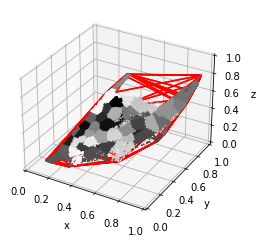

In [9]:
%matplotlib inline
figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
axes.scatter(
    points.T[0], 
    points.T[1], 
    points.T[2], 
    c=np.array([labels/(K-1)]*3).T,
    s=1)

for simplex in starting_hull.simplices:
    simplex = np.append(simplex, simplex[0])
    axes.plot(
        points[simplex, 0], 
        points[simplex, 1], 
        points[simplex, 2],
        "r-")
    
prep(axes)

plot.savefig("out/before.png", transparent=False, dpi=300)
plot.show()

### Results: With Manipulation

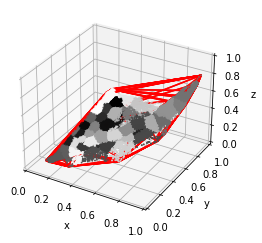

In [10]:
%matplotlib inline
figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
mask = np.where(labels != label)
axes.scatter(
    points[mask].T[0], 
    points[mask].T[1], 
    points[mask].T[2], 
    c=np.array([labels[mask]/(K-1)]*3).T,
    s=1)

for simplex in smallest_hull.simplices:
    simplex = np.append(simplex, simplex[0])
    axes.plot(
        points[mask][simplex, 0], 
        points[mask][simplex, 1], 
        points[mask][simplex, 2],
        "r-")
    
prep(axes)

plot.savefig("out/after.png", transparent=False, dpi=300)
plot.show()

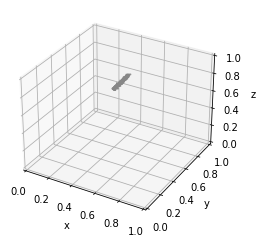

In [11]:
%matplotlib inline
# indices = np.arange(points.shape[0]); masked = set(mask[0])
# inverted_mask = np.fromiter((i for i in indices if i not in masked), dtype=np.uint)
excluded = points[labels == label]

figure = plot.figure()
axes = figure.add_subplot(111, projection="3d")
axes.scatter(
    excluded.T[0], 
    excluded.T[1], 
    excluded.T[2], 
    c=np.array([labels[labels == label]/(K-1)]*3).T,
    s=1)

prep(axes)

plot.savefig("out/excluded.png", transparent=False, dpi=300)
plot.show()